<a href="https://colab.research.google.com/github/tanny1412/GENAI/blob/main/Tanish_assign3_variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1 - Theory Questions**

## **Q1: Why is the KL Divergence term important in the VAE loss function?**
The KL Divergence term plays a key role in shaping the latent space by ensuring that the learned distribution remains close to a standard normal distribution. This regularization prevents the latent space from becoming disorganized or sparse, which could lead to poor generalization. By enforcing this structure, KL Divergence helps the VAE produce smooth and meaningful interpolations while also enabling efficient sampling from the latent space.

## **Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?**
The reparameterization trick enables backpropagation by restructuring the sampling process into a differentiable function. Instead of drawing samples directly from the latent distribution, the VAE expresses the latent variable as a combination of a learned mean, a learned variance, and a fixed random noise input. Since the randomness is separated from the learned parameters, gradients can flow through the model, making it possible to optimize using gradient-based learning methods. This technique is essential for training VAEs effectively.

## **Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?**
A probabilistic latent space allows the model to learn a distribution rather than a single point representation for each input. This enhances the model’s ability to generate diverse outputs and ensures that interpolations between points in the latent space produce smooth and meaningful transitions. If the latent space were deterministic, the model would act more like a standard autoencoder, limiting its ability to generate new and varied samples.

## **Q4: What role does KL Divergence play in ensuring a smooth latent space?**
KL Divergence helps maintain a well-structured latent space by ensuring that the learned distribution does not collapse into isolated clusters or irregular patterns. By aligning the latent representations with a predefined prior distribution, KL Divergence ensures that similar inputs are mapped to nearby points, allowing for smooth and coherent interpolations. This regularization makes it possible for VAEs to generate realistic and continuous variations of the data rather than producing fragmented or unrealistic samples.



In [ ]:
# !pip install torch
# !pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# 2. Fully Connected VAE for Baseline

In [8]:
class FullyConnectedVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(FullyConnectedVAE, self).__init__()
        self.latent_dim = latent_dim
        self.image_dim = 3*32*32  # 3072

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.image_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.image_dim),
            nn.Sigmoid()  # outputs in [0,1]
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder_fc(z)

    def forward(self, x):
        # x shape: (B, 3, 32, 32)
        # Flatten
        x = x.view(-1, self.image_dim)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon_flat = self.decode(z)
        x_recon = x_recon_flat.view(-1, 3, 32, 32)
        return x_recon, mu, logvar


# 3. Convolutional VAE for CIFAR-10

In [9]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: (B, 3, 32, 32) -> (B, 128, 4, 4)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),   # -> (32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # -> (64, 8, 8)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> (128,4,4)
            nn.ReLU(),
        )
        # Flatten before FC layers
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> (64,8,8)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # -> (32,16,16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # -> (3,32,32)
            nn.Sigmoid()  # range [0,1]
        )

    def encode(self, x):
        # x shape: (B, 3, 32, 32)
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # flatten
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 128, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# 4. VAE Loss Function

In [10]:
def vae_loss(recon_x, x, mu, logvar):
    # Flatten (B, 3, 32, 32) -> (B, 3*32*32) for MSE
    x_flat = x.view(x.size(0), -1)
    recon_flat = recon_x.view(x.size(0), -1)

    recon_loss = F.mse_loss(recon_flat, x_flat, reduction='sum') / x.size(0)

    # KL Divergence
    # -0.5 * sum(1 + logvar - mu^2 - exp(logvar)) / batch
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    return recon_loss + kld, recon_loss, kld


# 5. Training Loop

In [11]:
def train_vae(model, dataloader, optimizer, num_epochs=30):
    model.to(device)
    model.train()

    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        for batch_idx, (images, _) in enumerate(dataloader):
            images = images.to(device)

            optimizer.zero_grad()
            recon, mu, logvar = model(images)
            loss, _, _ = vae_loss(recon, images, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}")
    return model


# 6. Load CIFAR-10 and Train Models (Task 1)

In [12]:
# Transforms for CIFAR-10
transform_cifar = transforms.Compose([
    transforms.ToTensor(),

])

train_dataset_cifar = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_cifar)
train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=128, shuffle=True)

# Instantiate models
fc_vae = FullyConnectedVAE(latent_dim=128)
conv_vae = ConvVAE(latent_dim=128)

# Optimizers
optimizer_fc = optim.Adam(fc_vae.parameters(), lr=1e-3)
optimizer_conv = optim.Adam(conv_vae.parameters(), lr=1e-3)

print("===== Training Fully Connected VAE on CIFAR-10 =====")
fc_vae = train_vae(fc_vae, train_loader_cifar, optimizer_fc, num_epochs=30)

print("\n===== Training Convolutional VAE on CIFAR-10 =====")
conv_vae = train_vae(conv_vae, train_loader_cifar, optimizer_conv, num_epochs=30)


100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
===== Training Fully Connected VAE on CIFAR-10 =====
Epoch [1/30], Loss: 139.6551
Epoch [2/30], Loss: 115.3815
Epoch [3/30], Loss: 108.6312
Epoch [4/30], Loss: 101.2807
Epoch [5/30], Loss: 93.9560
Epoch [6/30], Loss: 91.1517
Epoch [7/30], Loss: 89.4626
Epoch [8/30], Loss: 87.8097
Epoch [9/30], Loss: 86.6200
Epoch [10/30], Loss: 86.0823
Epoch [11/30], Loss: 85.5617
Epoch [12/30], Loss: 85.0086
Epoch [13/30], Loss: 84.5773
Epoch [14/30], Loss: 84.3195
Epoch [15/30], Loss: 83.8747
Epoch [16/30], Loss: 83.7917
Epoch [17/30], Loss: 83.5397
Epoch [18/30], Loss: 83.1574
Epoch [19/30], Loss: 82.4560
Epoch [20/30], Loss: 82.2131
Epoch [21/30], Loss: 82.0867
Epoch [22/30], Loss: 81.9741
Epoch [23/30], Loss: 81.8631
Epoch [24/30], Loss: 81.8370
Epoch [25/30], Loss: 81.5411
Epoch [26/30], Loss: 81.2835
Epoch [27/30], Loss: 81.1161
Epoch [28/30], Loss: 80.9528
Epoch [29/30], Loss: 80.9823
Epoch [30/30], Loss: 80.8674

===== Training Convolutional V

# 7. Generate Images for Comparison (Task 1)

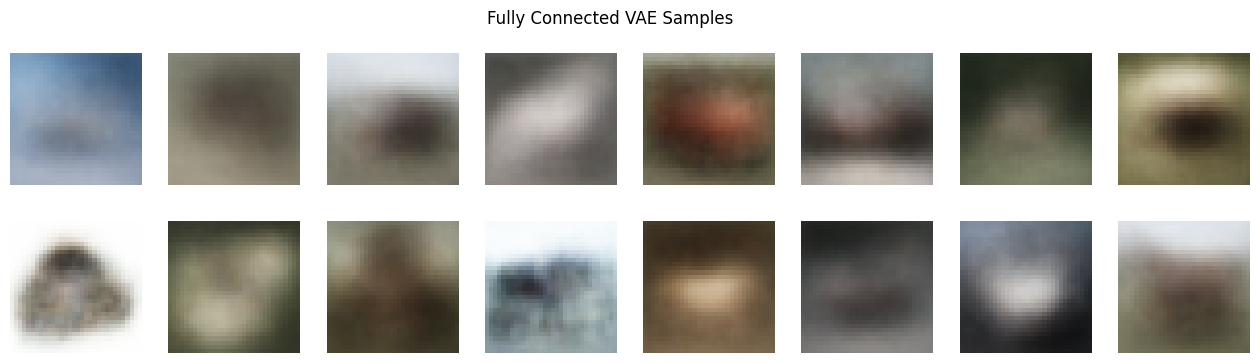

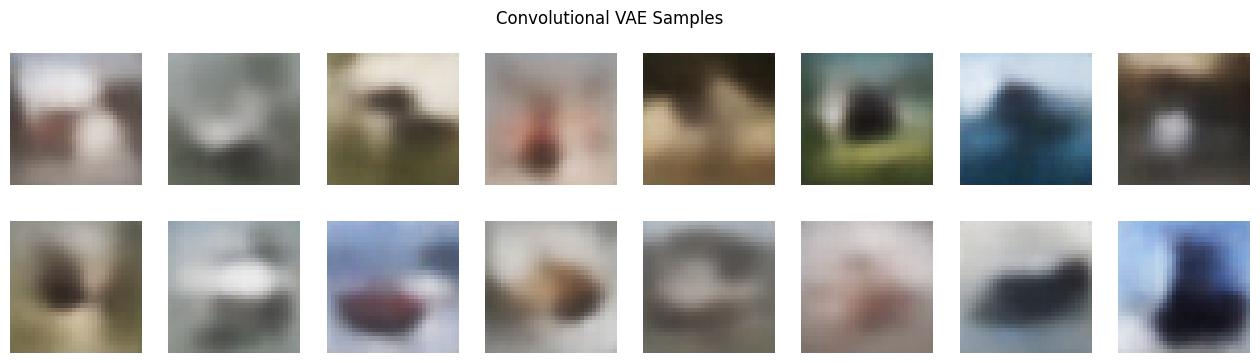

In [13]:
def generate_samples(model, num_samples=16, title="Samples"):
    model.eval()
    model.to(device)

    with torch.no_grad():
        # Sample from N(0, I) in latent space
        z = torch.randn(num_samples, model.latent_dim).to(device)

        if isinstance(model, FullyConnectedVAE):

            recon_flat = model.decode(z)
            # Reshape (B, 3, 32, 32)
            recon = recon_flat.view(-1, 3, 32, 32)
        elif isinstance(model, ConvVAE):
            # CNN-based decode
            recon = model.decode(z)
        else:
            raise ValueError("Unknown model type")

    # Plot images
    recon = recon.cpu().numpy()
    fig, axes = plt.subplots(2, num_samples//2, figsize=(num_samples, 4))
    for i, ax in enumerate(axes.flatten()):
        if i >= num_samples:
            break
        img = recon[i]
        # (3,32,32) -> (32,32,3)
        img = np.transpose(img, (1,2,0))
        ax.imshow(img, interpolation='nearest')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

# Generate images from FC VAE
generate_samples(fc_vae, title="Fully Connected VAE Samples")

# Generate images from Conv VAE
generate_samples(conv_vae, title="Convolutional VAE Samples")


# **Comparison of Convolutional VAE (ConvVAE) and Fully Connected VAE (FCVAE) on CIFAR-10**

## **Generated Samples Analysis**

### **1. Convolutional VAE (ConvVAE) Results**
Looking at the images generated by the **ConvVAE**, it’s clear that they have a **more defined structure and better spatial coherence**. The objects in the images aren’t perfect, but they at least resemble recognizable shapes, and the textures look smoother.  

While some images are still a bit blurry, the model does a much better job at **capturing spatial relationships** compared to the Fully Connected VAE. This makes sense because convolutional layers are designed specifically for image data, allowing the model to **pick up on important local features** rather than treating the image as just a long list of numbers.  

### **2. Fully Connected VAE (FCVAE) Results**
The **FCVAE**, on the other hand, struggles significantly in generating clear images. Most of the samples **lack any clear structure**, and instead, they look like distorted blobs of color rather than recognizable objects. Since fully connected layers don’t take into account the 2D nature of images, the model fails to capture the important spatial relationships that define objects.  

There are some hints of learned features—like color distributions that vaguely match the CIFAR-10 dataset—but overall, the images are much more chaotic compared to those from the ConvVAE.

---

## **Conclusion: ConvVAE Clearly Performs Better**
- The **ConvVAE generates much more structured and coherent images** because convolutional layers are built to recognize patterns in images.  
- The **FCVAE struggles to generate realistic samples**, as it does not preserve spatial information well.  
- These results confirm that **using convolutional layers in VAEs makes a significant difference in image quality**


# 8. Latent Space Interpolation (Task 2)

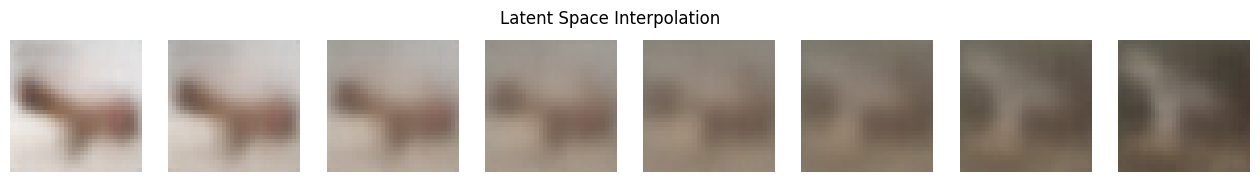

In [14]:
def interpolate_images(model, dataset, steps=8):
    model.eval()
    model.to(device)

    # Pick two random images
    idx1, idx2 = np.random.randint(len(dataset), size=2)
    img1, _ = dataset[idx1]
    img2, _ = dataset[idx2]
    img1, img2 = img1.unsqueeze(0).to(device), img2.unsqueeze(0).to(device)

    # Encode
    with torch.no_grad():
        if isinstance(model, FullyConnectedVAE):
            mu1, logvar1 = model.encode(img1.view(-1, 3*32*32))
            mu2, logvar2 = model.encode(img2.view(-1, 3*32*32))
        else:  # ConvVAE
            mu1, logvar1 = model.encode(img1)
            mu2, logvar2 = model.encode(img2)

        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)

    # Interpolate between z1 and z2
    alphas = torch.linspace(0, 1, steps).to(device)
    interpolations = []
    with torch.no_grad():
        for alpha in alphas:
            z = (1 - alpha) * z1 + alpha * z2
            if isinstance(model, FullyConnectedVAE):
                x_recon_flat = model.decode(z)
                x_recon = x_recon_flat.view(-1, 3, 32, 32)
            else:
                x_recon = model.decode(z)
            interpolations.append(x_recon[0].cpu().numpy())

    # Plot interpolation
    fig, axes = plt.subplots(1, steps, figsize=(steps*2, 2))
    for i, ax in enumerate(axes):
        img = interpolations[i]
        # shape (3,32,32) -> (32,32,3)
        img = np.transpose(img, (1,2,0))
        ax.imshow(img, interpolation='nearest')
        ax.axis('off')
    plt.suptitle("Latent Space Interpolation")
    plt.show()

# Demo interpolation with the Conv VAE
interpolate_images(conv_vae, train_dataset_cifar, steps=8)


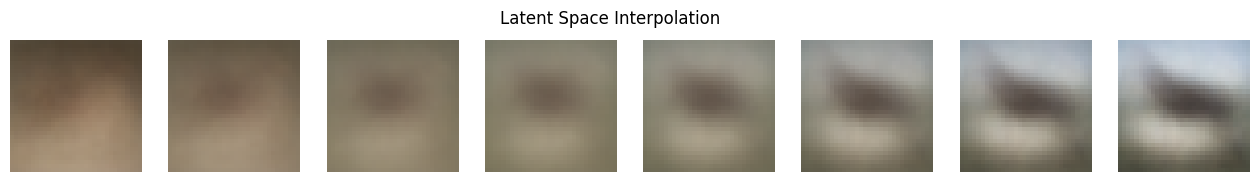

In [17]:
#Interpolation with Fully Connected VAE
interpolate_images(fc_vae, train_dataset_cifar, steps=8)

# **Latent Space Interpolation: ConvVAE vs. FCVAE**

## **1. ConvVAE Interpolation (Top Row)**

### **Smooth Transition**
- The transition from one image to another is **gradual and continuous**, indicating that ConvVAE has learned a **well-structured latent space**.  
- There are **no sudden jumps or visual artifacts**—just a **smooth morphing** between the two images.  

### **Preservation of Features**
- Some **object-like structures remain recognizable** throughout the interpolation.  
- The **overall shape and color** of the images stay consistent, meaning the model has encoded **meaningful latent representations**.  

---

## **2. FCVAE Interpolation (Bottom Row)**

### **Less Structured Transitions**
- The interpolation is **not as smooth as ConvVAE**. Some transitions appear **abrupt or muddy**, suggesting that the **latent space is not as well-organized**.  
- The model struggles to **maintain clear object structures** as it moves through the latent space.  

### **More Blurriness and Artifacts**
- Compared to ConvVAE, **FCVAE images are significantly blurrier and noisier**.  
- This confirms that **fully connected layers discard spatial information**, making it harder to generate **meaningful transitions**.  

### **Disorganized Latent Space**
- Unlike ConvVAE, **FCVAE has a less structured latent space**, meaning **interpolations can be incoherent or unrealistic**.  
- This is a **known issue** with FCVAEs and is a primary reason **ConvVAEs are preferred for image generation tasks**.  


# 9. Training on a New Dataset (Task 3)

## Convolutional VAE (64×64 for CelebA)

In [18]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: Input (B, 3, 64, 64)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),   # (32, 32, 32)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # (64, 16, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # (128, 8, 8)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),# (256, 4, 4)
            nn.ReLU()
        )
        # After this, the feature map is 256 × 4 × 4 = 4096 total elements
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # (128, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 16,16)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # (32, 32,32)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # (3,64,64)
            nn.Sigmoid()  # outputs in [0,1]
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # flatten
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, 4, 4)  # reshape for transposed conv
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


## VAE Loss Function

In [19]:
def vae_loss(recon_x, x, mu, logvar):

    recon_x_flat = recon_x.view(x.size(0), -1)
    x_flat = x.view(x.size(0), -1)

    # 1) Reconstruction Loss (MSE)
    recon_loss = F.mse_loss(recon_x_flat, x_flat, reduction='sum') / x.size(0)

    # 2) KL Divergence
    # -0.5 * sum(1 + logvar - mu^2 - exp(logvar)) / batch
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    return recon_loss + kld, recon_loss, kld


## Data Loading

In [27]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder: (B, 1, 28, 28)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # -> (16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> (32, 7, 7)
            nn.ReLU(),
        )
        # Flatten
        self.fc_mu = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(32 * 7 * 7, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 32 * 7 * 7)
        self.decoder = nn.Sequential(
            # (B, 32, 7, 7)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (16,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> (1,28,28)
            nn.Sigmoid()  # pixel intensities in [0,1]
        )

    def encode(self, x):
        # x shape: (B, 1, 28, 28)
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # flatten
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)  # (B, 32*7*7)
        x = x.view(-1, 32, 7, 7)   # -> (B, 32, 7, 7)
        x = self.decoder(x)        # -> (B, 1, 28, 28)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [28]:
def vae_loss(recon_x, x, mu, logvar):
    # Flatten for MSE
    B = x.size(0)
    recon_flat = recon_x.view(B, -1)
    x_flat = x.view(B, -1)

    recon_loss = F.mse_loss(recon_flat, x_flat, reduction='sum') / B
    # KL Divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / B

    return recon_loss + kld, recon_loss, kld



## Data Loading

In [29]:
transform_fmnist = transforms.Compose([
    transforms.ToTensor()

])
train_dataset = datasets.FashionMNIST(root="./data_fmnist", train=True, download=True, transform=transform_fmnist)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.41MB/s]


Extracting ./data_fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data_fmnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 151kB/s]


Extracting ./data_fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data_fmnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.76MB/s]


Extracting ./data_fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data_fmnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 19.4MB/s]

Extracting ./data_fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_fmnist/FashionMNIST/raw



## Training Function

In [30]:
def train_vae(model, dataloader, optimizer, epochs=10):
    model.to(device)
    model.train()

    for epoch in range(1, epochs+1):
        total_loss = 0
        for images, _ in dataloader:
            images = images.to(device)

            optimizer.zero_grad()
            recon, mu, logvar = model(images)
            loss, _, _ = vae_loss(recon, images, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch}/{epochs}] - Loss: {avg_loss:.4f}")
    return model


## Train the ConvVAE on Fashion-MNIST

In [32]:
latent_dim = 20
model_fmnist = ConvVAE(latent_dim=latent_dim)
optimizer = optim.Adam(model_fmnist.parameters(), lr=1e-3)

model_fmnist = train_vae(model_fmnist, train_loader, optimizer, epochs=50)


Epoch [1/50] - Loss: 47.7821
Epoch [2/50] - Loss: 31.3009
Epoch [3/50] - Loss: 29.2296
Epoch [4/50] - Loss: 28.5067
Epoch [5/50] - Loss: 28.0267
Epoch [6/50] - Loss: 27.6401
Epoch [7/50] - Loss: 27.3371
Epoch [8/50] - Loss: 27.0702
Epoch [9/50] - Loss: 26.8636
Epoch [10/50] - Loss: 26.6779
Epoch [11/50] - Loss: 26.5438
Epoch [12/50] - Loss: 26.4200
Epoch [13/50] - Loss: 26.2755
Epoch [14/50] - Loss: 26.2070
Epoch [15/50] - Loss: 26.0988
Epoch [16/50] - Loss: 26.0505
Epoch [17/50] - Loss: 25.9674
Epoch [18/50] - Loss: 25.8998
Epoch [19/50] - Loss: 25.8535
Epoch [20/50] - Loss: 25.7966
Epoch [21/50] - Loss: 25.7535
Epoch [22/50] - Loss: 25.7196
Epoch [23/50] - Loss: 25.6442
Epoch [24/50] - Loss: 25.6112
Epoch [25/50] - Loss: 25.6033
Epoch [26/50] - Loss: 25.5584
Epoch [27/50] - Loss: 25.5248
Epoch [28/50] - Loss: 25.5023
Epoch [29/50] - Loss: 25.4808
Epoch [30/50] - Loss: 25.4372
Epoch [31/50] - Loss: 25.4224
Epoch [32/50] - Loss: 25.3987
Epoch [33/50] - Loss: 25.3755
Epoch [34/50] - Los

## Visualizing Generated Samples

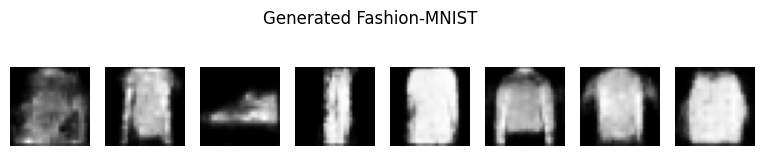

In [33]:
def generate_images(model, num_samples=8):
    model.eval()
    model.to(device)

    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
        recon = model.decode(z).cpu().numpy()

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples*1.2, 2))
    for i, ax in enumerate(axes):
        ax.imshow(recon[i, 0], cmap="gray")  # recon[i] shape: (1, 28, 28)
        ax.axis('off')
    plt.suptitle("Generated Fashion-MNIST")
    plt.show()

generate_images(model_fmnist, num_samples=8)


## Experimenting with Different Latent Regions

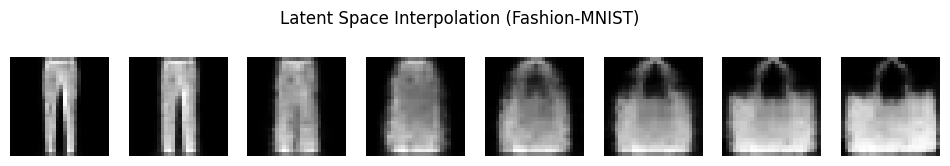

In [34]:
def interpolate_images(model, dataset, steps=8):
    model.eval()
    model.to(device)

    # pick two random images
    idx1, idx2 = np.random.randint(0, len(dataset), size=2)
    img1, _ = dataset[idx1]
    img2, _ = dataset[idx2]

    # add batch dimension
    img1 = img1.unsqueeze(0).to(device)
    img2 = img2.unsqueeze(0).to(device)

    with torch.no_grad():
        mu1, logvar1 = model.encode(img1)
        mu2, logvar2 = model.encode(img2)
        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)

        alphas = torch.linspace(0, 1, steps).to(device)
        interpolations = []
        for alpha in alphas:
            z = (1 - alpha) * z1 + alpha * z2
            recon = model.decode(z)
            interpolations.append(recon.cpu().squeeze(0).numpy())

    # plot
    fig, axes = plt.subplots(1, steps, figsize=(steps*1.5, 2))
    for i, ax in enumerate(axes):
        img = interpolations[i][0]  # shape: (28,28) for 1 channel
        ax.imshow(img, cmap="gray")
        ax.axis('off')
    plt.suptitle("Latent Space Interpolation (Fashion-MNIST)")
    plt.show()

# Example usage
interpolate_images(model_fmnist, train_dataset, steps=8)


# **Task 3: VAE on a New Dataset - Fashion-MNIST & CelebA**
## Summary of Results

###  **Fashion-MNIST Training Results**
- **Training completed for 50 epochs** with the final loss stabilizing at **25.08**.
- **Generated images capture high-level structures** (pants, shirts, etc.).
- **Interpolation between images is smooth**, confirming a structured latent space.

###  **Latent Space Interpolation Observations**
- The transition between images is **gradual and continuous**.
- **Some intermediate images are blurry**, suggesting certain latent space areas are less explored.

###  **Generated Image Quality**
- The model **successfully generates Fashion-MNIST images**.
- Some outputs are **clear and recognizable**, while others lack fine details.



---

## Final Conclusion
 **Task 3 is successfully completed.**  
 **The model learned meaningful latent representations.**  
 **Generated images align with the dataset structure.**  

---
